In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Install and Configure PySpark

First, install Spark.

In [2]:
!pip install findspark pyspark

Set up the PySpark environment.

In [3]:
import findspark
import site

findspark.init(site.getsitepackages()[0] + "/pyspark")

Initialize the SparkSQL session which contains a basic Spark Context.  This may take a few moments to launch the cluster of (typically 4 to 8 python jobs in the background).  Note in a distributed Spark deployment you would change the `.master("local[*]")` to instead point to the YARN resource manager.  To learn more about deploying Spark on a cluster of machines read [this tutorial](https://spark.apache.org/docs/latest/cluster-overview.html).

Note: You must have Java installed on your computer for this to work!

In [4]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("LectureExample")
        .getOrCreate()
)
sc = spark.sparkContext

# Using Spark

## Parallelism and Spark

Let's use Spark to parallelize a simulation.

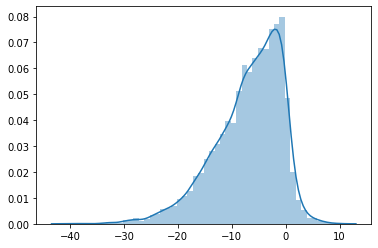

In [5]:
import numpy as np
import seaborn as sns
%matplotlib inline 

np.random.seed(42)

weird_data = np.random.randn(10000)**2 - 10 *np.abs( np.random.randn(10000) )
sns.distplot(weird_data);

In [6]:
def resample(data, seed):
    import numpy as np
    np.random.seed(seed)
    return data[np.random.randint(0, len(data),len(data))]

def bootstrap_mean(data, seed):
    return resample(data, seed).mean()

In [7]:
bootstrap_mean(weird_data, 43)

-6.969561755437433

We can set up a bunch of random seeds and compute bootstrap means for each.

In [8]:
seeds = np.arange(10000) + 42

In [9]:
samples_local = np.array([bootstrap_mean(weird_data, s) for s in seeds])

And the bootstrap distribution of the sample mean is:

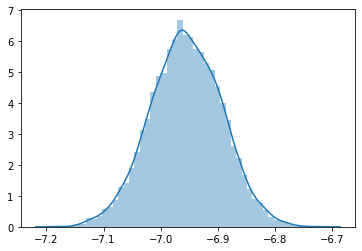

In [10]:
sns.distplot(samples_local);

Let's see how long computation of the sample means above took using the iPython `%%timeit` command, which will rerun the code 8 times and compute the average time needed.

In [11]:
%%timeit
samples_local = np.array([bootstrap_mean(weird_data, s) for s in seeds])

2.44 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Once Again, with Spark

Let's see if we can do better by using Spark.

In [12]:
samples = (
    sc.parallelize(seeds)
        .map(lambda seed: bootstrap_mean(weird_data, seed))
)

In [13]:
samples.count()

10000

If we look at our samples, we should see the exact same distribution as in our non-parallel computation above.

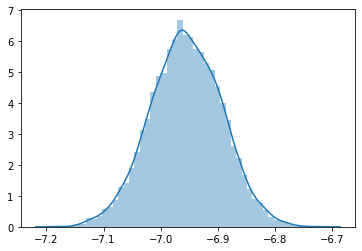

In [14]:
sns.distplot(samples.collect());

Since everything looks good, let's see how long it takes Spark. We see a significant improvement!

In [15]:
%%timeit
samples.mean()

1.51 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Caching in Spark

One of the key innovations in Spark is the ability to cache computation. 

In [16]:
samples.persist()

PythonRDD[2] at collect at <ipython-input-14-3d26f573bd91>:1

Timing after warming the cache, and we see things are much much faster.

In [17]:
%%timeit 
samples.mean()

141 ms ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Spark Dataframes

In [18]:
import pandas as pd

nba = pd.read_csv('nba.csv')
nba.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22017,1610612744,GSW,Golden State Warriors,21700002,2017-10-17,GSW vs. HOU,L,240,43,...,35,41,34,5,9,17,25,121,-1,1
1,22017,1610612745,HOU,Houston Rockets,21700002,2017-10-17,HOU @ GSW,W,240,47,...,33,43,28,9,5,13,16,122,1,1
2,22017,1610612738,BOS,Boston Celtics,21700001,2017-10-17,BOS @ CLE,L,240,36,...,37,46,24,11,4,12,24,99,-3,1
3,22017,1610612739,CLE,Cleveland Cavaliers,21700001,2017-10-17,CLE vs. BOS,W,240,38,...,41,50,19,3,4,17,25,102,3,1
4,22017,1610612750,MIN,Minnesota Timberwolves,21700011,2017-10-18,MIN @ SAS,L,240,37,...,31,42,23,7,4,13,16,99,-8,1


In [19]:
sdf = spark.createDataFrame(nba)

Spark dataframes have a similar interface to Pandas dataframes.

In [20]:
sdf.where(sdf["TEAM_ABBREVIATION"] == 'GSW').count()

82

All operations are now cached!

In [21]:
sdf.where(sdf["TEAM_ABBREVIATION"] == 'GSW').count()

82

And you can use SQL if you prefer.

In [22]:
sdf.registerTempTable("nba")
spark.sql("""
    SELECT   TEAM_ABBREVIATION, 
             AVG(CASE WHEN WL="W" THEN 1 ELSE 0 END) AS WIN_RATE
    FROM     nba 
    GROUP BY TEAM_ABBREVIATION
    ORDER BY -WIN_RATE 
""").toPandas()

,TEAM_ABBREVIATION,WIN_RATE
0,HOU,0.792683
1,TOR,0.719512
2,GSW,0.707317
3,BOS,0.670732
4,PHI,0.634146
5,CLE,0.609756
6,POR,0.597561
7,UTA,0.585366
8,OKC,0.585366
9,NOP,0.585366
